In [14]:
import scipy.io
import matplotlib.pyplot as plt
from skimage import feature, io, color
import numpy as np
import cv2
from tqdm import tqdm

# 1 Dataset

In [6]:
def load_svhn_dataset(train_path, test_path):
    train_data = scipy.io.loadmat(train_path)
    test_data = scipy.io.loadmat(test_path)

    train_images = train_data['X']
    train_labels = train_data['y']
    test_images = test_data['X']
    test_labels = test_data['y']

    train_images = np.transpose(train_images, (3, 0, 1, 2))
    test_images = np.transpose(test_images, (3, 0, 1, 2))

    return train_images, train_labels, test_images, test_labels

In [7]:
# Provide the paths to SVHN train and test datasets
train_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/train_32x32.mat'
test_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/test_32x32.mat'

train_images, train_labels, test_images, test_labels = load_svhn_dataset(train_path, test_path)

In [8]:
# print shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (73257, 32, 32, 3)
Train labels shape: (73257, 1)
Test images shape: (26032, 32, 32, 3)
Test labels shape: (26032, 1)


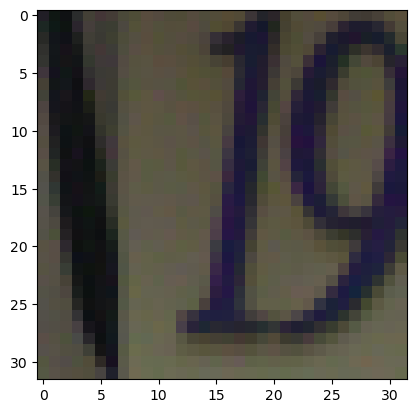

In [9]:
# show the first image
plt.imshow(train_images[0,:,:,:])
plt.show()

# 2 Feature Extraction

## 2.1 make a randomized search for the HP

### raw feature vectors

In [36]:
# 1. raw vectors. Concat pixels to one big vector. Very trivial
features1 = train_images.reshape(train_images.shape[0], -1)

In [37]:
features1.shape

(73257, 3072)

### grey scale images

In [ ]:
# Display the original image and LBP image
def plot_images(images, feature_images, idx = 0):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title("Original Image")

    plt.subplot(122)
    plt.imshow(feature_images[idx], cmap='gray')
    plt.title("Generated Image")

    plt.show()

In [15]:
# Preallocate the lbp_images array
def gray_scale(images):
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # create the lpb images
    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        feature_images[i, :, :, 0] = gray_image

    return feature_images


In [16]:
gray_images_train = gray_scale(train_images)
gray_images_test = gray_scale(test_images)

100%|██████████| 26032/26032 [00:00<00:00, 137677.87it/s]


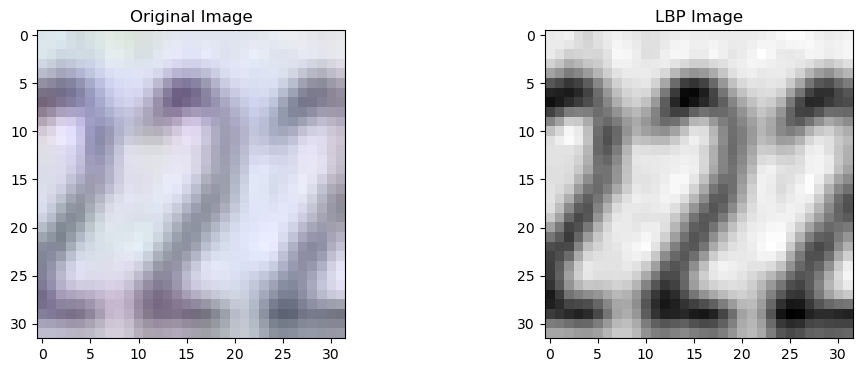

In [20]:
plot_images(train_images, gray_images_train, idx = 39)

### Local Binary Pattern

In [587]:
def lbp(images):

    # Preallocate the lbp_images array
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # create the lpb images
    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Compute LBP features
        radius = 3
        n_points = 8 * radius
        feature_images[i, :, :, 0] = feature.local_binary_pattern(gray_image, n_points, radius, method='uniform')

    return feature_images

In [585]:
lbp_images_train = lbp(train_images)
lbp_images_test = lbp(test_images)

100%|██████████| 26032/26032 [00:03<00:00, 8553.58it/s]


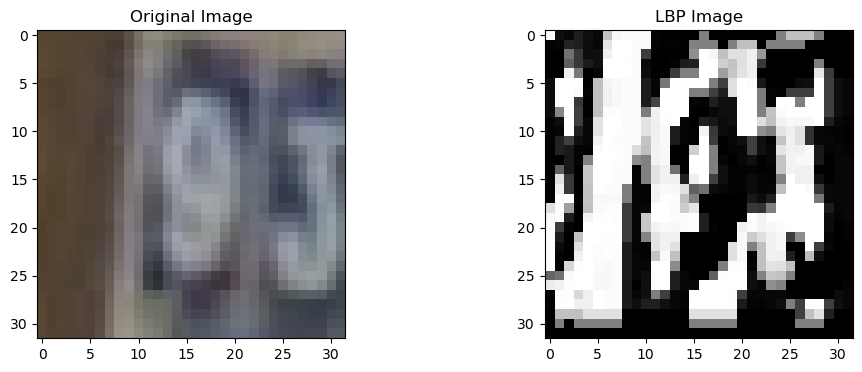

In [586]:
plot_images(train_images, lbp_images_train, idx = 6)

Difficulties:
what hyperparameters to choose?
sometimes the number is bright and sometimes the number is dark

### Harris Corner Detection

In [42]:
def hcd(images):

    # Preallocate the feature_images array
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # Perform Harris Corner Detection

    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Compute LBP features
        feature_images[i, :, :, 0] = cv2.cornerHarris(gray_image, blockSize=1, ksize=3, k=0.04)

    return feature_images

    # Threshold for corner detection
    #corner_threshold = 0.01 * corner_image.max()

In [43]:
hcd_images_train = hcd(train_images)
hcd_images_test = hcd(test_images)

100%|██████████| 26032/26032 [00:00<00:00, 38115.59it/s]


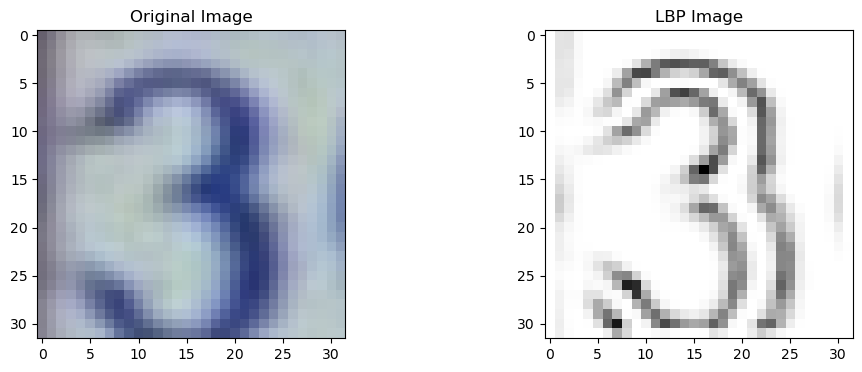

In [44]:
plot_images(train_images, hcd_images_train, idx = 1190)

problems: the filling is not white

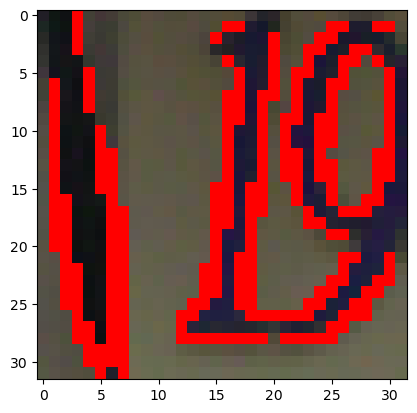

In [537]:
corner_image = hcd_images_train[0,:,:,0]
image = train_images[0,:,:,:]

# Threshold for corner detection
corner_threshold = 0.05 * corner_image.min()

# Create a copy of the original image
result_image = image.copy()

# Draw the detected corners on the result image
result_image[corner_image < corner_threshold] = [255, 0, 0]  # Set corners to red (BGR color format)

# Display the result
plt.imshow(result_image)

morgen: 2 weitere feature extraction methods
grid search implementieren für die hyperparameter
comparison based on cosine similarity

- was ich brauche ist das cropping auf die relevante zahl. --> alles andere im Bild sollte hintergrund sein
- combine local binary pattern matching and harris corner prediction

## 2.2

In [465]:
# compare based on cosine similarity -> how similar are the feature vectors?

# for each class calculate the average cosine similarity score. the lower the better



array([1], dtype=uint8)

# 3. Classification

## 3.1

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [22]:
gray_images_train.shape

(73257, 32, 32, 1)

In [45]:
X_train = hcd_images_train.reshape(hcd_images_train.shape[0], -1)
y_train = train_labels.ravel()
X_test = hcd_images_test.reshape(hcd_images_test.shape[0], -1)
y_test = test_labels.ravel()

In [46]:
X_test.shape

(26032, 1024)

In [51]:
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=20)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

In [52]:
metrics.accuracy_score(y_test, y_pred)

0.39993085433312847

## 3.2